**Author**: Nicolas Legrand <nicolas.legrand@cfin.au.dk>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
from typing import Union
import pymc as pm
import arviz as az
import aesara.tensor as at
from ipywidgets import widgets
from IPython.display import display

from hrd_simulation import simulate_hrd

# Disentangling the contribution of interoceptive accuracy from beliefs in cardiac interoception

The [Heart Rate Discrimination Task](https://www.sciencedirect.com/science/article/pii/S0301051121002325#fig0030) (HRD) is an experimental procedure designed to measure cardiac interoceptive beliefs. During the task, participants are asked to produce decision in comparing the frequency of their heart rate and a the frequency of a sequence of tones.

![title](https://github.com/embodied-computation-group/CardioceptionPaper/raw/main/figures/Fig1.png)

However, the exact strategy operated by the participant is still debated. This task, along with other pre-exixting procedure (e.g. HBC, HBD) are built on the notion that the participant (here also refered to as the *agent*, to comply with cognitive modelling terminology) use cardiac interoceptive signals, at least alongside other source of information, to inform the decision process. Here in this notebooks, we address this debated and still challengend notion by comparing two cognitive modles to explain the data obtain in ~500 participants. 

We start with describing the concepts operationalized in the task, and the implication of the different source of variability. We then formulate two competing hypothesis to explain the responses produced by the participants: 
* a `believer` model, in which the participant use prior knowledge to produce responses from the perception of the tones
* an `interoceptor` model in which the participant compare the frequency of the heart rate, perceived with some noise, to the frequency of the tones to produce the decisions.
We then use these model on simulated data to test parameters recovery performances and propose a new continuous metric able to estimate the proportion or both strategies use in the case of mixed profiles. In the last section, we use this validated model on ~500 participants and estimate the contribution of both strategies in the behaviors.

## Terminology

* **Cardiac beliefs**: The cardiac beliefs denote the infered heart rate by the participant. This belief does not require interoceptive signals to be hold, and it is assumed that they can also result from temporal interval perception (i.e. the participant expect one heartbeat every second) or semantic knowledge (the participant knows that his heart rate is probably between 60 and 80 BPM). The cardiac belief can also results from an efficient interoceptive capability, in which case the belief is dynamic and is updated by the perceived heart rate (`hr`) with some perceptual noise (see *Interoceptive accuracy*). Here, we will assume that the cardiacs beliefs can be characterized by a normal distribution, defined by `mean_belief` `std_belief`. 
* **Interoceptive accuracy**: the precision with which the heart rate are perceived by the participant. Every heart rate (`hr`) has a true value, the participant perceive these values with some noise, characterized by a normal distribution, defined by `mean_interoceptive_accuracy` and `std_interoceptive_accuracy`. 

## Mathematical formulation

### Task design

The average heart rate of the participant at each trial is coming from a normal distribtion with parameters $\mu_{hr}$ and $\sigma_{hr}$. 

$$ hr \sim \mathcal{N}(\mu_{hr}, \sigma_{hr})  $$

This distribution is important for both agents as it will define the values of the tones being tested as:

$$ tones = hr + \delta_{BPM} $$

Where $\delta_{BPM}$ is the intensity value being tested at each trial. During the classic HRD task, this value is generated using the [$\Psi$ method](https://www.sciencedirect.com/science/article/pii/S0042698998002855?via%3Dihub) in order to optimize the number of trials being tested. Because we do not have this limitation here, we will sample $n_{boot}$ times all the possible values from the range of possible values:  $\delta_{BPM} \in \{-50.5, 50.0...50, 50.5\}$, with $n_{boot} = 1000$ as default.

We define $F(x, \alpha, \beta)$ as the cumilative normal distribution function with threshold $\alpha$ and slope $\beta$ as:

$$ F(x, \alpha, \beta) = \frac{1}{2} + \frac{1}{2} * erf(\frac{x-\alpha}{\beta*\sqrt{2}})$$

where $erf$ is the error function.

### Cardiac believer

The `cardiac believer` is using a prior distribution $Belief$ over the heart rate with parameters $\mu_{belief}$ and $\sigma_{belief}$ to produce decision from the tones with:

$$ belief \sim \mathcal{N}(\mu_{belief}, \sigma_{belief})  $$

The probability of answering faster is the given by:

$$ p_{Faster} = F(tones, \mu_{belief}, \sigma_{belief}) $$

And the responses are Bernouilli trials from this probability

$$ responses \sim Bernoulli(p_{Faster}) $$

### Cardiac interoceptor

The `cardiac interoceptor` is using the cardiac signal to inform its decision on every trials. The heart rate ($hr$) is perceived with some noise ($cardiac noise$) parametrized by an interoceptive precision $\sigma_{noise}$ and interoceptive accuracy $\mu_{noise}$:

$$ cardiac noise \sim \mathcal{N}(\mu_{noise}, \sigma_{noise}) $$

The probability of answering faster is the given by:

$$ p_{Faster} = F(\delta_{BPM}, \mu_{noise}, \sigma_{noise}) $$

And the responses are Bernouilli trials from this probability

$$ responses \sim Bernoulli(p_{Faster}) $$







## Simulating the task
To get a better overview of the task results, we are going to simulate responses from an interoceptor and a believer agent and to plot their responses in both respective domains (i.e. the beliefs over the heart rates for the believer, and the belief over the difference between the heart rate and the tones for the interoceptor). 

In [44]:
def plot_hrd_simulations(
    mean_hr: float, 
    std_hr: float, 
    mean_belief: float = 60.0, 
    std_belief: float = 10.0, 
    interoceptive_accuracy: float = -7.0,
    interoceptive_precision: float = 10.0
):

    # Responses provided by the interoceptor agent
    interoceptor_df = simulate_hrd(
        mean_hr=mean_hr, 
        std_hr=std_hr,
        interoceptive_accuracy=interoceptive_accuracy, 
        interoceptive_precision=interoceptive_precision,
        agent="interoceptor",
        n_boot=1000
    )

    # Responses provided by the believer agent
    believer_df = simulate_hrd(
        mean_hr=mean_hr, 
        std_hr=std_hr,
        mean_belief=mean_belief, 
        std_belief=std_belief,
        agent="believer",
        n_boot=1000
    )
    
    believer_df["tones"] = believer_df.tones.to_numpy().round()
    interoceptor_df["tones"] = interoceptor_df.tones.to_numpy().round()
    
    # Plot results
    _, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 7), sharex='col', sharey=True)
    
    axs[0, 0].set_title("Interoceptive domain")
    axs[0, 0].set_ylabel("Cardiac interoceptor")
    axs[0, 0].plot(
        interoceptor_df.groupby("alphas").mean().index,
        interoceptor_df.groupby("alphas").mean()["responses"],
        color="#c44e52"
    )

    axs[1, 0].set_ylabel("Cardiac believer")
    axs[1, 0].plot(
        believer_df.groupby("alphas").mean().index,
        believer_df.groupby("alphas").mean()["responses"],
    )

    axs[0, 1].set_title("Belief domain")
    axs[0, 1].plot(
        interoceptor_df.groupby("tones").mean().index,
        interoceptor_df.groupby("tones").mean()["responses"],
        color="#c44e52"
    )

    axs[1, 1].plot(
        believer_df.groupby("tones").mean().index,
        believer_df.groupby("tones").mean()["responses"]
    )

    axs[1, 0].set_xlabel(r"$\Delta BPM$")
    axs[1, 1].set_xlabel("Tones frequencies (BPM)")
    plt.show()

In [45]:
widgets.interact(
    plot_hrd_simulations, 
    mean_hr=(20, 120), 
    std_hr=(.001, 20), 
    mean_belief=(20, 120), 
    std_belief=(.001, 20),
    interoceptive_accuracy=(-50.0, 50.0), 
    interoceptive_precision=(.001, 30)
);

interactive(children=(IntSlider(value=70, description='mean_hr', max=120, min=20), FloatSlider(value=10.000499…

# Bayesian modelling

In [74]:
def cumulative_normal(x, alpha, beta):
    """Cumulative distribution function for the standard normal distribution"""
    return 0.5 + 0.5 * at.erf((x - alpha) / (beta * at.sqrt(2)))

# Parameters recovery
## Interoceptors

In [138]:
hrd_df = simulate_hrd(
    mean_hr=60, 
    std_hr=10,
    mean_interoceptive_accuracy=-7.0, 
    std_interoceptive_accuracy=10.0,
    agent="interoceptor"
)

In [139]:
# Format data before modelling
n_trials = len(hrd_df)
trials_vec = np.arange(0, len(hrd_df))
n_total = np.ones(len(hrd_df))
responses = hrd_df.responses.to_numpy()

In [140]:
with pm.Model() as interoceptive_model:
    
    # Interoceptive noise parameters
    mean_interoceptive_accuracy = pm.Uniform("mean_interoceptive_accuracy", lower=-50.0, upper=50.0)
    std_interoceptive_accuracy = pm.Uniform("std_interoceptive_accuracy", lower=0.1, upper=30.0)
    
    thetaij = pm.Deterministic(
        "thetaij", cumulative_normal(
            hrd_df.alphas.to_numpy(), 
            alpha=mean_interoceptive_accuracy, 
            beta=std_interoceptive_accuracy
        )
    )

    rij_ = pm.Binomial("rij", p=thetaij, n=n_total, observed=responses)

In [141]:
with interoceptive_model:
    idata_interoceptive = pm.sample(chains=4, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean_interoceptive_accuracy, std_interoceptive_accuracy]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


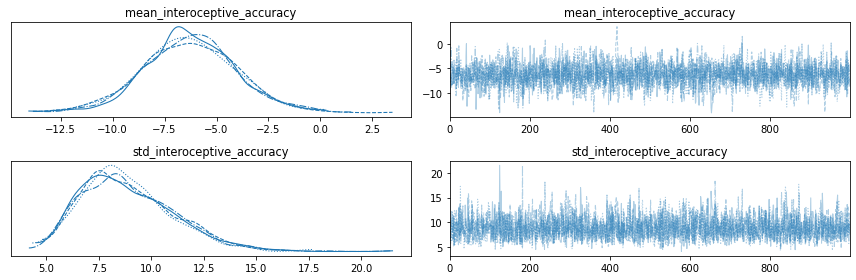

In [142]:
az.plot_trace(idata_interoceptive, var_names=["mean_interoceptive_accuracy", "std_interoceptive_accuracy"])
plt.tight_layout()

## Believers

In [143]:
hrd_df = simulate_hrd(
    mean_hr=70, 
    std_hr=10,
    mean_belief=60.0, 
    std_belief=5.0,
    agent="believer"
)

In [144]:
# Format data before modelling
n_trials = len(hrd_df)
trials_vec = np.arange(0, len(hrd_df))
n_total = np.ones(len(hrd_df))
responses = hrd_df.responses.to_numpy()

In [145]:
with pm.Model() as believing_model:
    
    # Interoceptive noise parameters
    mean_belief = pm.Uniform("mean_belief", lower=20.0, upper=180.0)
    std_belief = pm.Uniform("std_belief", lower=0.1, upper=50.0)
    
    thetaij = pm.Deterministic(
        "thetaij", cumulative_normal(
            hrd_df.tones.to_numpy(), 
            alpha=mean_belief, 
            beta=std_belief
        )
    )

    rij_ = pm.Binomial("rij", p=thetaij, n=n_total, observed=responses)

In [146]:
with believing_model:
    idata_believing = pm.sample(chains=4, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean_belief, std_belief]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


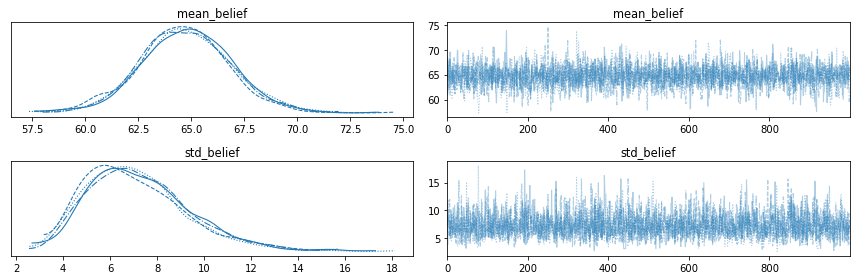

In [147]:
az.plot_trace(idata_believing, var_names=["mean_belief", "std_belief"])
plt.tight_layout()

In [60]:
hrd_df = simulate_hrd(mean_hr=60, std_hr=10, mean_belief=60, std_belief=0.001, agent="believer")